# Modelling

## Packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from matplotlib import pyplot as plt

print(f" Found and Using {len(tf.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(df, target_col):

    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    x_scaled = StandardScaler().fit_transform(x.values)
    
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = np_utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map)

## Read Data

In [3]:
#df = pd.read_csv('data/IRIS.csv')
#df = pd.read_csv('data/rolled_df.csv')
df = pd.read_csv('data/tab_df.csv')

In [4]:
target_col = 'target'

print(f'Record count : {len(df)}')
print('--------------------------')
print(df[target_col].value_counts())
print('--------------------------')
print(df[target_col].value_counts(normalize=True))

df.head(5)

Record count : 186166
--------------------------
same        180369
decrease      2992
increase      2805
Name: target, dtype: int64
--------------------------
same        0.968861
decrease    0.016072
increase    0.015067
Name: target, dtype: float64


,tick,diff,gain,loss,avg_gain,avg_loss,rs,rsi,ssma,lsma,sema,lema,target
0,1.14541,0.00009,0.00009,0.00000,0.000029,0.000043,0.683333,40.594059,1.145300,1.146044,1.145337,1.145868,same
1,1.14547,0.00006,0.00006,0.00000,0.000034,0.000043,0.783333,43.925234,1.145296,1.146039,1.145361,1.145859,same
2,1.14541,-0.00006,0.00000,0.00006,0.000034,0.000047,0.712121,41.592920,1.145295,1.146032,1.145370,1.145849,same
3,1.14533,-0.00008,0.00000,0.00008,0.000033,0.000053,0.621622,38.333333,1.145301,1.146019,1.145363,1.145837,same
4,1.14526,-0.00007,0.00000,0.00007,0.000031,0.000058,0.543210,35.200000,1.145292,1.146011,1.145344,1.145824,same


## Scale and encode data

In [5]:
x_scaled, y_encoded, y_map = scale_x_encode_y(df, target_col)
pd.DataFrame(x_scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.918814,0.634227,0.509799,-0.490691,-0.433466,-0.047757,-0.014336,-0.595740,1.910700,1.965980,1.913523,1.953723
1,1.923261,0.423124,0.174228,-0.490691,-0.310759,-0.047757,-0.014329,-0.389712,1.910404,1.965602,1.915316,1.953049
2,1.918814,-0.421285,-0.496915,0.170102,-0.310759,0.072830,-0.014334,-0.533962,1.910329,1.965120,1.915973,1.952291
3,1.912885,-0.562020,-0.496915,0.390366,-0.331210,0.233612,-0.014340,-0.735562,1.910774,1.964141,1.915433,1.951418
4,1.907696,-0.491653,-0.496915,0.280234,-0.372112,0.374296,-0.014346,-0.929354,1.910107,1.963541,1.914048,1.950449


## Train test split

In [6]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

## Neural Network

### Network building

In [7]:
model = Sequential([
    Dense(units = 16, activation='relu', input_shape=[len(train_x[0])]),
    Dense(units = 32, activation='relu'),
    Dense(units = 3, activation='softmax')
])

In [8]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),    
    metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                208       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________


### Parameters

In [10]:
epoch_val         = 5
batch_size_val    = 256

verbose_val       = 2
workers_val       = -1

### Training

In [11]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
         verbose=verbose_val)

Epoch 1/5
582/582 - 1s - loss: 0.1434 - accuracy: 0.9693 - val_loss: 0.0834 - val_accuracy: 0.9728
Epoch 2/5
582/582 - 1s - loss: 0.0769 - accuracy: 0.9733 - val_loss: 0.0741 - val_accuracy: 0.9742
Epoch 3/5
582/582 - 1s - loss: 0.0722 - accuracy: 0.9744 - val_loss: 0.0726 - val_accuracy: 0.9745
Epoch 4/5
582/582 - 1s - loss: 0.0712 - accuracy: 0.9747 - val_loss: 0.0715 - val_accuracy: 0.9746
Epoch 5/5
582/582 - 1s - loss: 0.0706 - accuracy: 0.9751 - val_loss: 0.0713 - val_accuracy: 0.9756


### DNN Results

In [12]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.67      0.40      0.50       623
    increase       0.70      0.38      0.49       530
        same       0.98      0.99      0.99     36081

    accuracy                           0.98     37234
   macro avg       0.79      0.59      0.66     37234
weighted avg       0.97      0.98      0.97     37234



## RF Results

In [13]:
%%time
clf = RandomForestClassifier() 
clf.fit(train_x, train_y)
predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.66      0.42      0.51       623
    increase       0.69      0.42      0.52       530
        same       0.98      0.99      0.99     36081

    accuracy                           0.98     37234
   macro avg       0.78      0.61      0.67     37234
weighted avg       0.97      0.98      0.97     37234

Wall time: 42.7 s


### RF Feature importance

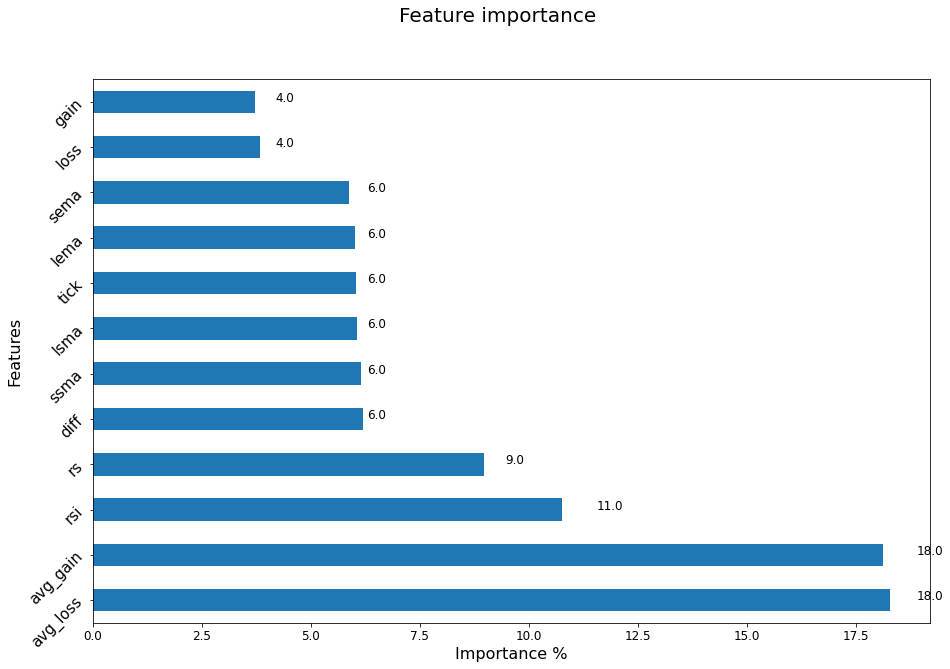

In [15]:
x_cols = df.columns[df.columns != 'target']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(15).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(1.05*value, index, str(value), fontsize=12)